In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../src/utils'))
import data_utils

In [2]:
ROOT_PATH = "D:\ADA Project (SSD)"
DATA_PATH = os.path.join(ROOT_PATH, 'data')
TIME_SERIES_PATH = os.path.join(DATA_PATH, 'time_series')
CHANNELS_PATH = os.path.join(DATA_PATH, 'channels')
VIDEO_METADATA_PATH = os.path.join(DATA_PATH, 'video_metadata')

print(f"ROOT_PATH items: {os.listdir(ROOT_PATH)}\n")
print(f"DATA_PATH items: {os.listdir(DATA_PATH)}\n")
print(f"TIME_SERIES_PATH items: {os.listdir(TIME_SERIES_PATH)}\n")
print(f"CHANNELS_PATH items: {os.listdir(CHANNELS_PATH)}\n")
print(f"VIDEO_METADATA_PATH items: {os.listdir(VIDEO_METADATA_PATH)}\n")

ROOT_PATH items: ['.git', '.gitignore', 'README.md', 'data', 'pip_requirements.txt', 'results.ipynb', 'src', 'test Notebooks', 'tests', '.idea']

DATA_PATH items: ['some_data_file_that_you_cleaned_and_saved.csv', 'youtube_comments.tsv.gz', 'yt_metadata_en.jsonl.gz', 'num_comments.tsv.gz', 'df_timeseries_en.tsv.gz', 'num_comments_authors.tsv.gz', 'df_channels_en.tsv.gz', 'time_series', 'music', 'channels', 'video_metadata']

TIME_SERIES_PATH items: ['Autos & Vehicles_timeseries.tsv.gz', 'Comedy_timeseries.tsv.gz', 'Education_timeseries.tsv.gz', 'Entertainment_timeseries.tsv.gz', 'Film and Animation_timeseries.tsv.gz', 'Gaming_timeseries.tsv.gz', 'Howto & Style_timeseries.tsv.gz', 'Music_timeseries.tsv.gz', 'News & Politics_timeseries.tsv.gz', 'Nonprofits & Activism_timeseries.tsv.gz', 'People & Blogs_timeseries.tsv.gz', 'Pets & Animals_timeseries.tsv.gz', 'Science & Technology_timeseries.tsv.gz', 'Sports_timeseries.tsv.gz', 'Travel & Events_timeseries.tsv.gz']

CHANNELS_PATH items: ['Au

# Processing the Video Metadata

We start by grouping all the video metadata by category and saving each group to a separate file. This will allow us to work with smaller files and load only the data we need for a specific category.

In [3]:
def save_chunk_grouped_by_col(df, column, output_dir="datasets"):   
    """
    Saves a chunk of data into separate files for each category in the specified column.
    :param df (pd.DataFrame): DataFrame containing the data chunk.
    :param column (str): Column to group the data by.
    :param output_dir (str): Output directory to save the files.
    """
    # Check if the column exists
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the DataFrame.")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Group by the specified column
    grouped = df.groupby(column)

    for group, df_group in grouped:
        # Define the output file path
        output_file = os.path.join(output_dir, f"{group}.parquet")
        df_group.to_parquet(output_file, mode='a', compression='gzip')


def process_data(data_filename, chunk_size=10_000, column_to_group="categories"):
    """
    Process a large JSONL file by reading it in chunks, grouping the data by a specified column, and saving each group to a separate Parquet file.
    :param data_filename (str): Path to the data file.
    :param chunk_size (int): The number of rows to read in each chunk.
    :param column_to_group (str): The column to group the data by.
    """
    with pd.read_json(data_filename, lines=True, compression='gzip', chunksize=chunk_size) as reader:
        for chunk in reader:
            save_chunk_grouped_by_col(chunk, column=column_to_group)
            

def convert_jsonl_to_parquet(data_filename, output_filename, chunk_size=100_000):
    """
    Convert a JSONL file to Parquet format.
    :param data_filename (str): Path to the JSONL file.
    :param output_filename (str): Path to the output Parquet file.
    """
    dfs = []
    with pd.read_json(data_filename, lines=True, compression='gzip', chunksize=chunk_size) as reader:
        for chunk in reader:
            dfs.append(chunk)
    df = pd.concat(dfs)
    df.to_parquet(output_filename, compression='gzip')

The following cell creates both jsonl and parquet files for each category in the YouTube metadata. Run it only if you want to create the files (it takes a long time).

In [4]:
# data_filename = "datasets/yt_metadata_en.jsonl.gz"
# column_to_group = "categories"

# # Create one jsonl file per YouTube category
# process_data(data_filename, chunk_size=chunk_size, column_to_group=column_to_group)

# # Convert the JSONL files to Parquet format
# for filename in os.listdir("datasets/video_metadata"):
#     if filename.endswith(".jsonl.gz"):
#         data_filename = os.path.join("datasets/video_metadata", filename)
#         output_filename = data_filename.replace(".jsonl.gz", ".parquet")
#         convert_jsonl_to_parquet(data_filename, output_filename)

In [5]:
# # Remaining files to convert (too big for my computer)
# filenames = ["Entertainment", "Gaming"]
# for filename in filenames:
#     data_filename = os.path.join("datasets/video_metadata", filename + ".jsonl.gz")
#     output_filename = data_filename.replace(".jsonl.gz", ".parquet")
#     convert_jsonl_to_parquet(data_filename, output_filename)

Now we can load the metadata for a specific category and explore its contents.

In [6]:
# music_metadata = pd.read_parquet("datasets/video_metadata/Music.parquet")

In [7]:
# music_metadata.head()

We can check if we get the correct number of rows by comparing it with the number given in [the Youniverse Paper](https://arxiv.org/abs/2012.10378) (Table 1). 

In [8]:
# print(f"Number of music videos: {len(music_metadata)}")

# Processing the Channel Data

The goal here is to map `channel_id`s to their corresponding `name_cc`. We will first group the channels by category and save them to separate files. Then, we will add a 'channel_name' column to the video metadata by merging it with the channel data.

In [37]:
# output_dir_channels = "datasets/channels"
df_channels = pd.read_csv(f"{DATA_PATH}/channels.tsv.gz", sep='\t')
df_channels.head(3)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087


In [39]:
data_utils.save_data_grouped_by_category(df_channels, column="category_cc", output_dir=f"{CHANNELS_PATH}")

Let's first see how many channels we have in each category.

In [15]:
df_channels["category_cc"].value_counts()

category_cc
Music                    24285
Entertainment            22951
Gaming                   20143
People & Blogs           18413
Howto & Style            11875
Education                 7803
Film and Animation        6875
Sports                    5148
Science & Technology      4864
Comedy                    3767
Autos & Vehicles          3705
News & Politics           2263
Travel & Events           1989
Pets & Animals            1292
Nonprofits & Activism      969
Name: count, dtype: int64

In [17]:
category = "Music"
music_channels = pd.read_csv(f"{CHANNELS_PATH}/{category}.csv", sep='\t')
music_channels.head()

,Unnamed: 0,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,6,Music,2014-03-12,UCFFbwnve3yF62-tVXkTyHqg,Zee Music Company,43451109,4241,13.0,2.087
1,9,Music,2006-08-08,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,42000000,154,17.0,2.087
2,11,Music,2007-02-09,UCfM3zsQsOnfWNUppiycmBuw,EminemMusic,39000000,117,20.0,2.087
3,12,Music,2007-01-22,UC9CoOnJkIBMdeijd9qYoT_g,Ariana Grande,38090343,133,23.0,2.087
4,13,Music,2006-09-20,UCqECaJ8Gagnn7YCbPEzWH6g,Taylor Swift,35800000,172,26.0,2.087


Let's see which channels are the most popular (the original frame is already sorted by subscriber count).

In [18]:
music_channels.sort_values(by="subscriber_rank_sb")[["name_cc", "subscribers_cc"]].head()

,name_cc,subscribers_cc
0,Zee Music Company,43451109
1,Ed Sheeran,42000000
2,EminemMusic,39000000
3,Ariana Grande,38090343
4,Taylor Swift,35800000


Let's now add a column with the channel name to the music metadata.

In [13]:
music_metadata = music_metadata.merge(music_channels[["channel", "name_cc", "subscriber_rank_sb"]], left_on="channel_id", right_on="channel", how="left")

Since we only have channels with more than 10k subscribers and more than 10 videos, we can expect that all videos have a channel name. Let's see how many videos are left once we get rid of the ones without a channel name.

In [14]:
music_metadata = music_metadata.dropna()
music_metadata.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,channel,name_cc,subscriber_rank_sb
3,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:26.995798,Subscribe for more horror music: https://www.y...,0.0,H20js4rsYeI,112,102.0,"horror music,best horror music,scary music,cre...",Horror Trailer Music - The Terror | Atmospheri...,2019-10-02 00:00:00,2643.0,UCzWdpFOflXTOk5Gsi2aJ67g,Horror Music World,535218.0
4,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:27.615035,Subscribe for more horror music: https://www.y...,1.0,bM06MQ--Daw,157,63.0,"horror music,best horror music,scary music,cre...",Synapse Trailer Music - Padded Room | Epic Hyb...,2019-10-01 00:00:00,1304.0,UCzWdpFOflXTOk5Gsi2aJ67g,Horror Music World,535218.0
5,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:28.279103,Subscribe for more horror music: https://www.y...,1.0,VQg8ibAOVwM,100,80.0,"horror music,best horror music,scary music,cre...",Horror Trailer Music - Something In The Baseme...,2019-09-25 00:00:00,1891.0,UCzWdpFOflXTOk5Gsi2aJ67g,Horror Music World,535218.0
6,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:28.899642,Subscribe for more horror music: https://www.y...,0.0,wdTPh9_8hR0,112,105.0,"horror music,best horror music,scary music,cre...",Synapse Trailer Music - Infared | Dark Epic Hy...,2019-09-24 00:00:00,2461.0,UCzWdpFOflXTOk5Gsi2aJ67g,Horror Music World,535218.0
7,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:29.543375,Subscribe for more horror music: https://www.y...,0.0,dtbu8aHUdSk,131,94.0,"horror music,best horror music,scary music,cre...",Colossal Trailer Music - My Beloved Death | Da...,2019-09-22 00:00:00,2384.0,UCzWdpFOflXTOk5Gsi2aJ67g,Horror Music World,535218.0


In [15]:
music_metadata = music_metadata.drop(columns=["channel"])
music_metadata.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,name_cc,subscriber_rank_sb
3,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:26.995798,Subscribe for more horror music: https://www.y...,0.0,H20js4rsYeI,112,102.0,"horror music,best horror music,scary music,cre...",Horror Trailer Music - The Terror | Atmospheri...,2019-10-02 00:00:00,2643.0,Horror Music World,535218.0
4,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:27.615035,Subscribe for more horror music: https://www.y...,1.0,bM06MQ--Daw,157,63.0,"horror music,best horror music,scary music,cre...",Synapse Trailer Music - Padded Room | Epic Hyb...,2019-10-01 00:00:00,1304.0,Horror Music World,535218.0
5,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:28.279103,Subscribe for more horror music: https://www.y...,1.0,VQg8ibAOVwM,100,80.0,"horror music,best horror music,scary music,cre...",Horror Trailer Music - Something In The Baseme...,2019-09-25 00:00:00,1891.0,Horror Music World,535218.0
6,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:28.899642,Subscribe for more horror music: https://www.y...,0.0,wdTPh9_8hR0,112,105.0,"horror music,best horror music,scary music,cre...",Synapse Trailer Music - Infared | Dark Epic Hy...,2019-09-24 00:00:00,2461.0,Horror Music World,535218.0
7,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:29.543375,Subscribe for more horror music: https://www.y...,0.0,dtbu8aHUdSk,131,94.0,"horror music,best horror music,scary music,cre...",Colossal Trailer Music - My Beloved Death | Da...,2019-09-22 00:00:00,2384.0,Horror Music World,535218.0


In [16]:
print(f"Number of music videos with channel name: {len(music_metadata)}")

Number of music videos with channel name: 7487307


In [3]:
# Save this file to parquet 
os.makedirs("datasets/music", exist_ok=True)
music_metadata.to_parquet("datasets/music/music_metadata.parquet", compression='gzip')


KeyboardInterrupt



# Processing the Time Series Data

After loading the data, we group it by category and save each group to a separate file.
Here we explore a given category's time series data. We start by merging the time series data with the channel data to get the channel name. 

In [41]:
time_series = pd.read_csv(f"{DATA_PATH}/time_series.tsv.gz", sep='\t', compression='gzip')

In [8]:
grouped = time_series.groupby("category")

os.makedirs("datasets/time_series", exist_ok=True)
for cat, group in grouped:
    group.to_csv(f"datasets/time_series/{cat}_timeseries.tsv.gz", sep='\t', compression='gzip')

In [6]:
music_time_series = pd.read_csv(f"{TIME_SERIES_PATH}/Music_timeseries.tsv.gz", sep='\t', compression='gzip')
music_time_series = music_time_series.merge(music_channels[["channel", "name_cc", "subscriber_rank_sb"]], on="channel", how="left")
music_time_series.sample(5)

NameError: name 'music_channels' is not defined

## Taylor Swift's Time Series Data 

We can for example plot the evolution of the number of views for a specific channel.

In [42]:
taylor_swift = music_time_series.query("name_cc == 'Taylor Swift'")
taylor_swift.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,name_cc,subscriber_rank_sb
1293991,UCqECaJ8Gagnn7YCbPEzWH6g,Music,2016-10-17 00:00:00,1.183324e+08,90493.125000,1.419545e+06,0.000000,138,0,0,Taylor Swift,26.0
1293992,UCqECaJ8Gagnn7YCbPEzWH6g,Music,2016-10-24 00:00:00,1.184618e+08,129432.875000,1.419854e+06,309.375000,138,0,0,Taylor Swift,26.0
1293993,UCqECaJ8Gagnn7YCbPEzWH6g,Music,2016-10-30 23:00:00,1.185970e+08,135173.808290,1.420184e+06,330.497409,138,0,0,Taylor Swift,26.0
1293994,UCqECaJ8Gagnn7YCbPEzWH6g,Music,2016-11-06 23:00:00,1.187264e+08,129455.280252,1.420436e+06,251.216132,138,0,0,Taylor Swift,26.0
1293995,UCqECaJ8Gagnn7YCbPEzWH6g,Music,2016-11-13 23:00:00,1.188343e+08,107908.520833,1.420599e+06,163.583333,138,0,0,Taylor Swift,26.0


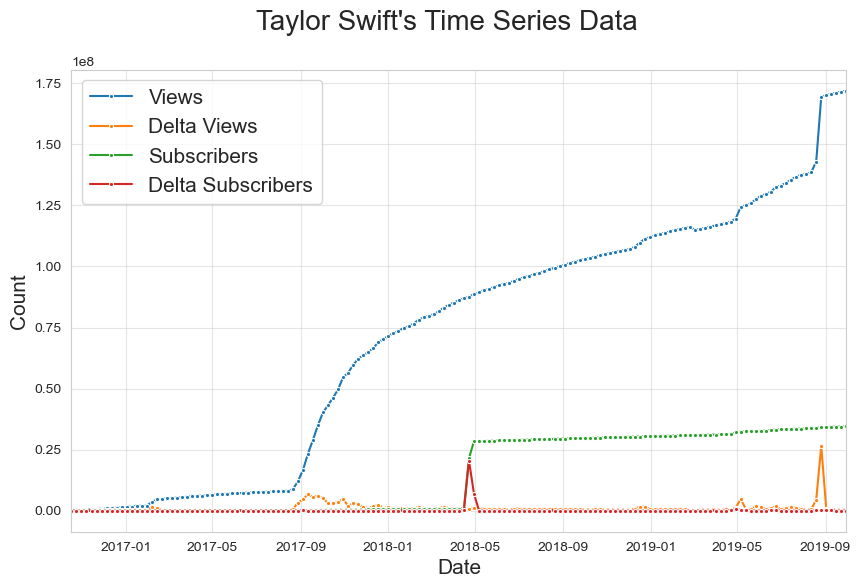

In [45]:
taylor_swift = taylor_swift.copy()
taylor_swift["datetime"] = pd.to_datetime(taylor_swift["datetime"].copy())
taylor_swift = taylor_swift.sort_values(by="datetime")

# Normalize the views and subscribers
taylor_swift["views"] = taylor_swift["views"] - taylor_swift["views"].min()
taylor_swift["subs"] = taylor_swift["subs"] - taylor_swift["subs"].min()

fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
fig.suptitle("Taylor Swift's Time Series Data", fontsize=20)
sns.lineplot(data=taylor_swift, x="datetime", y="views", ax=axs, label="Views", marker='.', linestyle='-')
sns.lineplot(data=taylor_swift, x="datetime", y="delta_views", ax=axs, label="Delta Views", marker='.', linestyle='-')
sns.lineplot(data=taylor_swift, x="datetime", y="subs", ax=axs, label="Subscribers", marker='.', linestyle='-')
sns.lineplot(data=taylor_swift, x="datetime", y="delta_subs", ax=axs, label="Delta Subscribers", marker='.', linestyle='-')
plt.xlabel("Date", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.5)
plt.xlim(taylor_swift["datetime"].min(), taylor_swift["datetime"].max())
plt.show()

## Distributions of the variations in views, subscribers and videos for the Music category

In [2]:
def plot_category_distribution(df, column, category, x_log, y_log, print_summary=False):
    """
    Plots a violin plot and a histogram of the distribution of a column for a specific category.
    :param df (pd.DataFrame): DataFrame containing the data
    :param column (str): Name of the column to plot
    :param category (str): Name of the category 
    :param x_log (bool): if True, the data will be log-transformed on the x-axis
    :param y_log (bool): if True, plots the y-axis on a log scale
    :param print_summary (bool): if True, prints the summary statistics of the column
    """

    data = np.log(df[column] + 1) if x_log else df[column]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.violinplot(x=data, fill=False, ax=axes[0], linewidth=1)
    axes[0].set_title(f"Distribution of {column} for the {category} category", fontsize=16)
    axes[0].set_xlabel(f"{column}", fontsize=12)
    axes[0].grid(True, alpha=0.5)
    
    sns.histplot(data, bins=100, ax=axes[1])
    axes[1].set_title(f"Distribution of {column} for the {category} category", fontsize=16)
    axes[1].set_xlabel(f"{column}", fontsize=12)
    axes[1].set_ylabel("Count", fontsize=12)
    axes[1].grid(True, alpha=0.5)
    
    if y_log:        
        axes[1].set_ylabel("log(Count)", fontsize=12)
        axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    if print_summary:
        print(f"Summary statistics for the {column}:")
        print(df[column].describe())

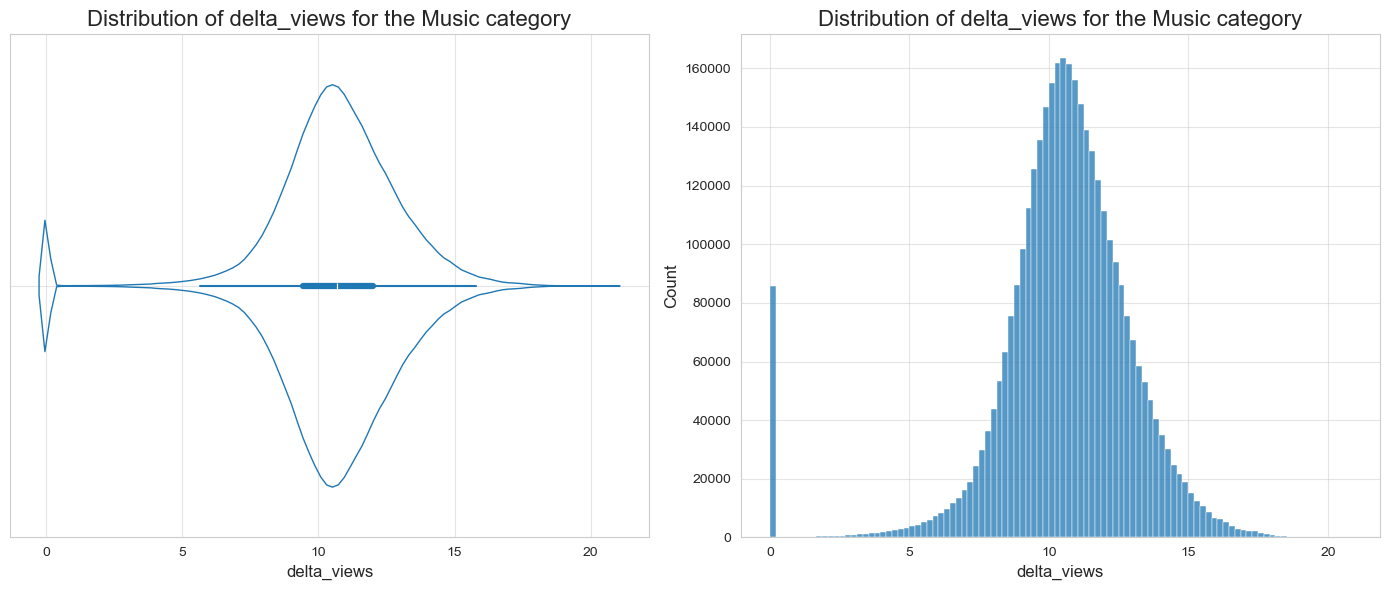

Summary statistics for the weekly variations in views:
count    3.532411e+06
mean     5.024186e+05
std      4.831397e+06
min      0.000000e+00
25%      1.270412e+04
50%      4.314738e+04
75%      1.612692e+05
max      1.104146e+09
Name: delta_views, dtype: float64


In [104]:
plot_category_distribution(music_time_series, "delta_views", "Music", x_log=True, y_log=False)

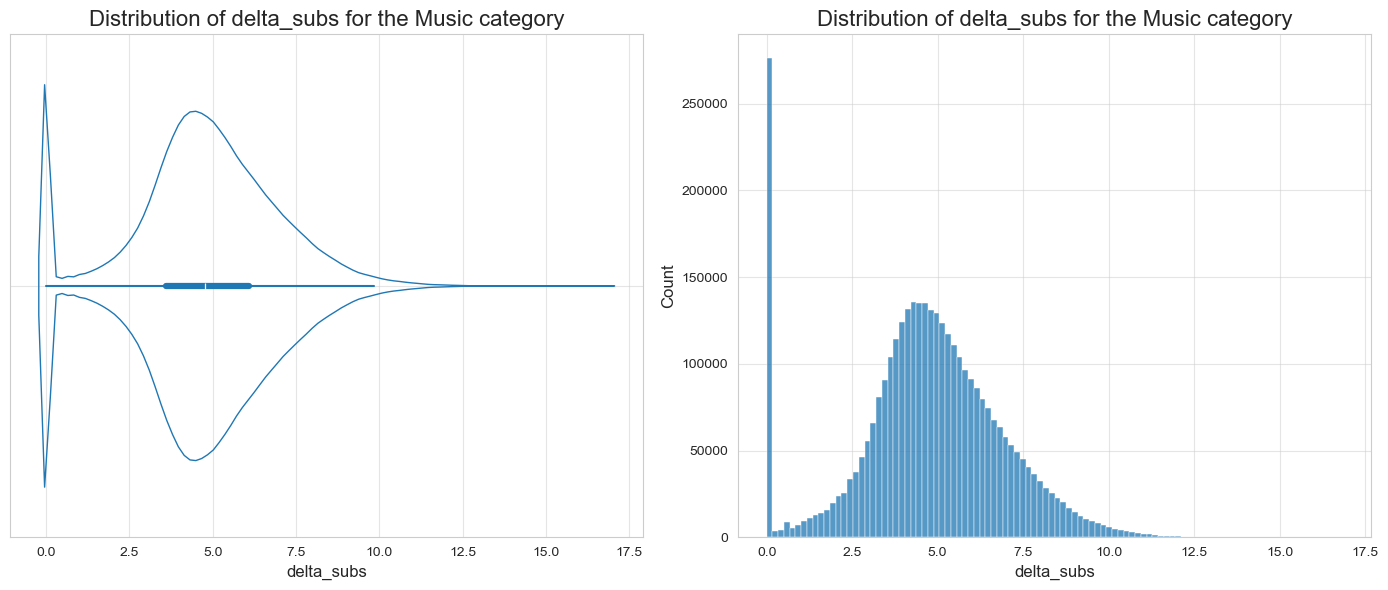

Summary statistics for the weekly variations in views:
count    3.532411e+06
mean     5.024186e+05
std      4.831397e+06
min      0.000000e+00
25%      1.270412e+04
50%      4.314738e+04
75%      1.612692e+05
max      1.104146e+09
Name: delta_views, dtype: float64


In [105]:
plot_category_distribution(music_time_series, "delta_subs", "Music", x_log=True, y_log=False)

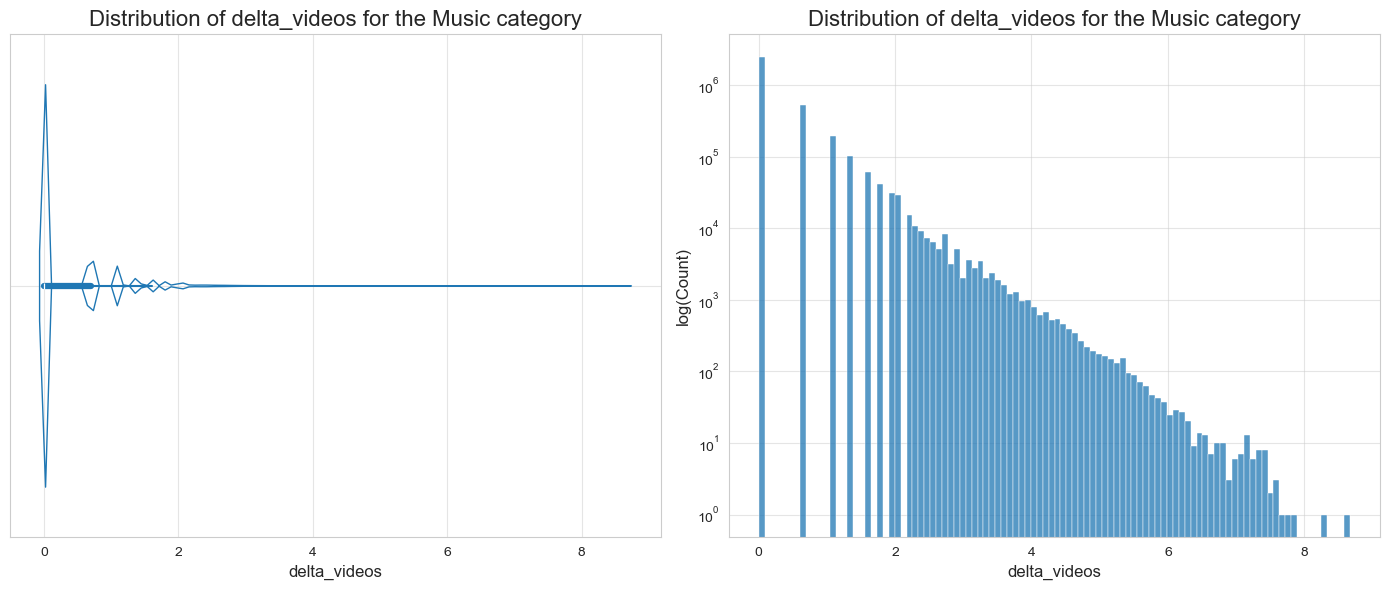

Summary statistics for the weekly variations in views:
count    3.532411e+06
mean     5.024186e+05
std      4.831397e+06
min      0.000000e+00
25%      1.270412e+04
50%      4.314738e+04
75%      1.612692e+05
max      1.104146e+09
Name: delta_views, dtype: float64


In [106]:
plot_category_distribution(music_time_series, "delta_videos", "Music", x_log=True, y_log=True)

## Comparison of the distributions across categories

In [50]:
def compare_categories_hist(df, column, x_log, y_log, kde=True, palette='tab10'):
    """
    Compares the distribution of a column across multiple categories.
    :param list_df: List of DataFrames containing the data 
    :param column: Column to compare
    :param x_log: if True, the data will be log-transformed on the x-axis
    :param y_log: if True, plots the y-axis on a log scale
    """
    # Transform the data if necessary
    if x_log:
        temp_df = df.copy()
        temp_df[column] = np.log(df[column] + 1)
    else:
        temp_df = df
        
    # Plot the distribution for each category
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.histplot(temp_df, x=column, bins=100, hue="category", ax=ax, palette=palette, kde=kde, alpha=0.2)
    ax.set_title(f"Comparison of the distribution of {column} across categories", fontsize=20, fontweight='bold')
    ax.set_xlabel(f"log({column}+1)", fontsize=16) if x_log else ax.set_xlabel(f"{column}", fontsize=16)
    ax.set_ylabel("Count", fontsize=16)
    ax.grid(True, alpha=0.3)
    if y_log:
        ax.set_ylabel("log(Count)", fontsize=16)
        ax.set_yscale('log')
    plt.show()
    
    
def compare_categories_boxplot(df, column, x_log, palette='tab10'):
    """
    Compares the distribution of a column across multiple categories using a boxplot.
    :param list_df: List of DataFrames containing the data 
    :param column: Column to compare
    :param x_log: if True, the data will be log-transformed on the x-axis
    """
    # Transform the data if necessary
    if x_log:
        temp_df = df.copy()
        temp_df[column] = np.log(df[column] + 1)
    else: 
        temp_df = df
        
    # Plot the distribution for each category
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.boxenplot(data=temp_df, y="category", x=column, palette=palette, hue="category")
    ax.set_title(f"Comparison of the distribution of {column} across categories", fontsize=20, fontweight='bold')
    ax.set_xlabel("Category", fontsize=16)
    ax.set_ylabel(f"log({column}+1)", fontsize=16) if x_log else ax.set_ylabel(f"{column}", fontsize=16)
    ax.grid(True, alpha=0.3)
    plt.show()

In [45]:
# Load the time series data for the categories
categories = ["Entertainment", "Music", "Gaming"]
time_series_list = [pd.read_csv(f"datasets/time_series/{cat}_timeseries.tsv.gz", sep='\t', compression='gzip') 
                    for cat in categories]
df = pd.concat(time_series_list)

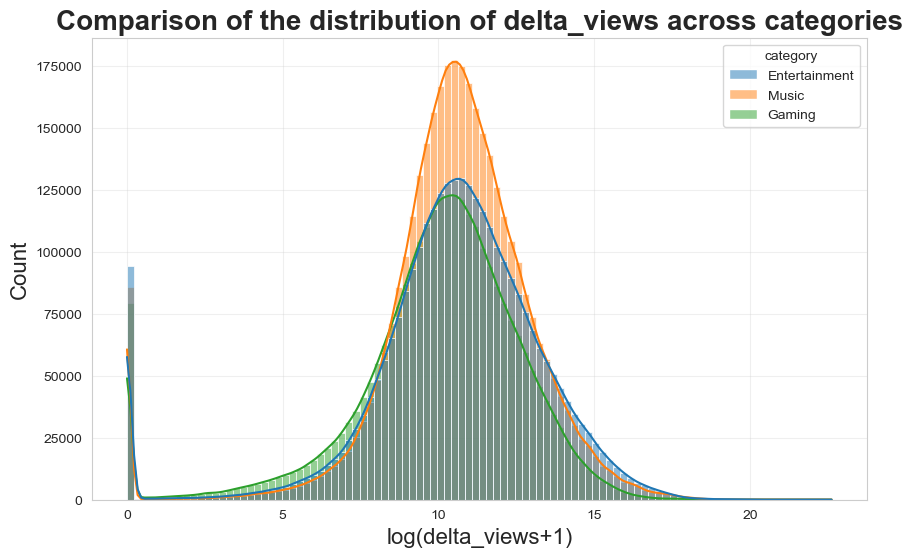

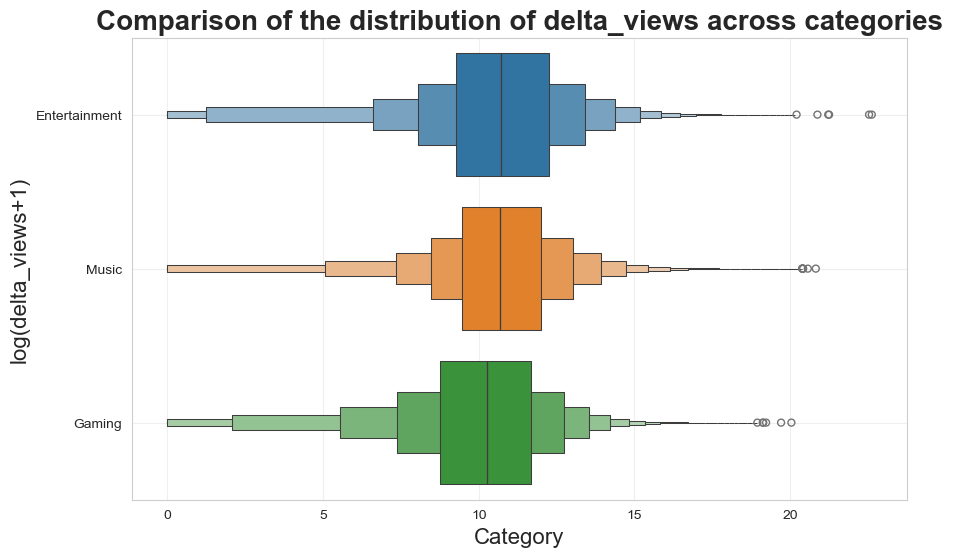

In [46]:
compare_categories_hist(df, "delta_views", x_log=True, y_log=False)
compare_categories_boxplot(df, "delta_views", x_log=True)